
# Machine Learning (Doctorado) — Notebook 01  
## Workflow, *train/val/test*, y **data leakage**

**Objetivos de la semana 1**
- Entender el flujo de trabajo típico en ML: **problema → datos → split → baseline → modelo → evaluación → iteración**.
- Implementar correctamente **train/validation/test** (y cuándo usar cada uno).
- Identificar y evitar **data leakage** (fugas de información), una de las causas más comunes de resultados “demasiado buenos”.
- Practicar con:
  - **Datos simulados** (para controlar el “mundo” y entender conceptos).
  - Un **dataset tabular real pequeño** (para ver el workflow realista).

> Recomendación: ejecuta este notebook **en orden**, y responde los ejercicios al final (puedes crear un “cuaderno de respuestas” o usar celdas Markdown).



---
## 0. Setup y convenciones

En este notebook:
- Usaremos `numpy/pandas` para datos y `scikit-learn` para modelos y *pipelines*.
- Fijaremos una **semilla** para reproducibilidad.
- Separaremos claramente:
  - **Train**: se usa para **ajustar** el modelo.
  - **Validation**: se usa para **decidir** (tuning, selección de modelo, umbral, etc.).
  - **Test**: se usa **una sola vez al final**, como estimación honesta del desempeño.

**Regla de oro**: nada de lo que “aprenda” del dataset (imputación, escalado, selección de variables, PCA, etc.) debe mirar **test**.


In [1]:

# Imports
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix
)
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

# Reproducibilidad
RANDOM_STATE = 7
rng = np.random.default_rng(RANDOM_STATE)

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 140)



---
## 1. El flujo de trabajo (mental model)

Un workflow mínimo y reproducible en ML suele verse así:

1) **Definir el problema** (qué se predice y por qué).  
2) **Reunir datos** (y entender limitaciones).  
3) **Definir la partición** (*split*) antes de mirar demasiado:
   - `train` para aprender,
   - `val` para decidir,
   - `test` para evaluar honestamente.
4) **Baseline** (si tu modelo no le gana a un baseline, hay un problema).  
5) **Pipeline de datos** (imputación, encoding, escalado, etc.).  
6) **Entrenar modelos**.  
7) **Evaluar** con métricas y gráficos.  
8) **Iterar** (tuning, features, modelos) usando *val*.  
9) **Test final** una sola vez.  
10) **Comunicar** (métricas + limitaciones + reproducibilidad).

En lo que sigue implementaremos este workflow para:
- una tarea de **regresión** (target continuo), y
- una tarea de **clasificación binaria**.



---
## 2. Splits correctos: *train/val/test*

### 2.1 ¿Por qué no basta con train/test?
Porque durante el desarrollo tomarás decisiones (hiperparámetros, features, etc.). Si usas `test` para decidir, tu `test` deja de ser “nuevo” y el desempeño quedará inflado.

### 2.2 Recomendación práctica
- En cursos/experimentos: `train/val/test` (por ejemplo 60/20/20 o 70/15/15).
- En proyectos más serios: **cross-validation** en train (lo veremos más adelante), manteniendo un test final.


In [2]:

def split_train_val_test(X, y, test_size=0.20, val_size=0.20, random_state=7, stratify=None):
    '''
    Split en 3 partes:
    - test_size: proporción total para test
    - val_size: proporción total para val (del total)
    '''
    # 1) separar test
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=stratify
    )

    # 2) separar train vs val dentro de trainval
    val_ratio_within = val_size / (1.0 - test_size)
    strat2 = y_trainval if stratify is not None else None
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, test_size=val_ratio_within, random_state=random_state, stratify=strat2
    )

    return X_train, X_val, X_test, y_train, y_val, y_test

print("Helper split_train_val_test listo.")


Helper split_train_val_test listo.



---
## 3. Datos simulados (para entender conceptos)

### 3.1 Simulación de regresión
Creamos un dataset con:
- variables numéricas,
- señal + ruido,
- target continuo.

Luego comparamos:
- **Baseline**: predecir la media.
- **Modelo**: regresión lineal.


## ¿Qué es un `DummyRegressor` y por qué es importante?

Un **baseline** es un modelo de referencia *muy simple* que establecemos como “piso” de desempeño. La idea es responder primero: **¿cuánto logro sin Machine Learning “de verdad”?** Si un modelo sofisticado no supera a un baseline razonable, entonces (casi siempre) hay un problema: el dataset no tiene señal suficiente, el preprocesamiento es incorrecto, hay fuga de información (*leakage*), o la métrica/partición no está bien planteada.

### `DummyRegressor` (scikit-learn)
`DummyRegressor` es una implementación estándar de un **baseline para regresión**. No intenta aprender relaciones entre variables; en cambio, produce predicciones usando reglas simples basadas en el conjunto de entrenamiento.

Las estrategias típicas son:

- **`strategy="mean"`**: predice siempre la **media** de `y` en el *train*.  
  \[
  \hat{y}(x) = \bar{y}_{train}
  \]

- **`strategy="median"`**: predice siempre la **mediana** de `y` en el *train*.  
  Es más robusta a valores atípicos.

- **`strategy="quantile"`**: predice un cuantíl fijo (por ejemplo, el 0.9) de `y` en *train*.  
  Útil si el costo de subestimar/sobreestimar es asimétrico.

- **`strategy="constant"`**: predice una constante definida por ti.

### ¿Qué hace exactamente?
1. En `fit(X_train, y_train)`, **no** “aprende” coeficientes ni patrones en `X`; solo **calcula un valor resumen** de `y_train` (media, mediana, etc.).
2. En `predict(X)`, devuelve ese mismo valor para **todas** las filas:
   - misma predicción, independientemente de los *features*.

### ¿Para qué lo necesitamos?
- **Piso de desempeño**: valida que tu pipeline tiene sentido. Si tu modelo no supera al baseline, tu esfuerzo no está aportando.
- **Diagnóstico rápido**: te ayuda a detectar problemas de datos (ruido alto, target mal definido, features irrelevantes).
- **Comparación justa**: en reportes y papers, un baseline claro aumenta la credibilidad.
- **Control contra autoengaño**: evita celebrar métricas que en realidad son fáciles de lograr (por ejemplo, con datasets muy triviales).

### Idea clave
> Un buen baseline no es “el peor modelo posible”; es un **referente mínimo razonable**.  
> Tu objetivo inicial no es “tener un modelo complejo”, sino **superar consistentemente al baseline en validación/test**.


In [14]:

# =============================
# 3.1 Simulación: REGRESIÓN
# =============================
n = 800
p = 6

X_reg = rng.normal(size=(n, p))
beta = np.array([2.5, -1.2, 0.0, 3.0, 0.0, 1.5])
noise = rng.normal(scale=2.0, size=n)
y_reg = 10 + X_reg @ beta + noise


In [30]:
pd.concat([pd.DataFrame(X_reg,columns=["var {}".format(i) for i in range(len(X_reg.colum))]),pd.DataFrame(y_reg,columns=["target"])],axis=1)

ValueError: Shape of passed values is (800, 6), indices imply (800, 800)

In [18]:
Xr_train, Xr_val, Xr_test, yr_train, yr_val, yr_test = split_train_val_test(
    X_reg, y_reg, test_size=0.20, val_size=0.20, random_state=RANDOM_STATE
)

# Baseline
base_reg = DummyRegressor(strategy="mean")
base_reg.fit(Xr_train, yr_train)

# Modelo
lin = LinearRegression()
lin.fit(Xr_train, yr_train)

def reg_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mse),
        "R2": r2_score(y_true, y_pred),
    }

val_base = reg_metrics(yr_val, base_reg.predict(Xr_val))
val_lin  = reg_metrics(yr_val, lin.predict(Xr_val))

pd.DataFrame([val_base, val_lin], index=["Baseline(mean)", "LinearRegression"])


,MAE,RMSE,R2
Baseline(mean),3.891116,4.879552,-0.004991
LinearRegression,1.606520,1.998602,0.831401


In [19]:

# Evaluación final en TEST (solo después de decidir el modelo)
test_base = reg_metrics(yr_test, base_reg.predict(Xr_test))
test_lin  = reg_metrics(yr_test, lin.predict(Xr_test))

pd.DataFrame([test_base, test_lin], index=["Baseline(mean)", "LinearRegression"])


,MAE,RMSE,R2
Baseline(mean),3.868833,4.771216,-0.000917
LinearRegression,1.610357,2.075816,0.810540



### 3.2 Simulación de clasificación binaria
Generamos un target binario a partir de una “score” latente y la pasamos por una sigmoide.

Compararemos:
- **Baseline**: clase mayoritaria.
- **Modelo**: regresión logística.

Además vemos **ROC-AUC** y **PR-AUC**.


In [20]:

# =============================
# 3.2 Simulación: CLASIFICACIÓN BINARIA (con desbalance)
# =============================
n = 1500
p = 8

X_clf = rng.normal(size=(n, p))
w = np.array([1.5, -2.0, 0.0, 0.8, 0.0, 1.2, 0.0, -0.6])
logits = -1.0 + X_clf @ w + rng.normal(scale=0.7, size=n)  # intercepto negativo => menos positivos
p_true = 1 / (1 + np.exp(-logits))
y_clf = rng.binomial(1, p_true)


In [26]:
pd.concat([pd.DataFrame(X_clf),pd.DataFrame(y_clf)],axis=1)

,0,1,2,3,4,5,6,7,0
0,2.104797,-1.363868,-0.394224,1.137328,-0.064204,-0.921091,-1.115423,1.198685,1
1,0.817650,-1.938134,-1.362794,0.675945,1.669949,-0.517635,0.995948,-1.584188,1
2,-1.660214,-1.235769,0.534125,0.235175,0.757780,-1.758880,1.715969,-0.385396,0
3,2.722354,0.289490,-1.803069,-0.011862,-0.831819,1.592795,0.250051,1.295707,1
4,-0.786938,-0.755355,0.173939,0.100506,-0.922755,0.554547,1.212184,-0.335483,1
...,...,...,...,...,...,...,...,...,...
1495,0.826993,-1.094795,0.754266,1.020393,-1.230348,0.986334,1.366808,1.585931,1
1496,1.471163,0.745028,0.767709,-0.523786,1.952478,0.209717,1.087450,0.740132,0
1497,0.141657,-0.964073,0.754791,0.273662,-0.803656,1.650138,0.495709,-0.302394,1
1498,-0.377479,1.430045,-0.254626,-0.228485,-1.754142,-0.097880,-0.460565,1.048123,0


In [21]:
# split estratificado (importante en clasificación)
Xc_train, Xc_val, Xc_test, yc_train, yc_val, yc_test = split_train_val_test(
    X_clf, y_clf, test_size=0.20, val_size=0.20, random_state=RANDOM_STATE, stratify=y_clf
)

# Baseline: clase más frecuente
base_clf = DummyClassifier(strategy="most_frequent")
base_clf.fit(Xc_train, yc_train)

# Modelo: Logistic Regression
logreg = LogisticRegression(max_iter=5000)
logreg.fit(Xc_train, yc_train)

def clf_metrics(y_true, proba, thr=0.5):
    pred = (proba >= thr).astype(int)
    return {
        "Accuracy": accuracy_score(y_true, pred),
        "Precision": precision_score(y_true, pred, zero_division=0),
        "Recall": recall_score(y_true, pred, zero_division=0),
        "F1": f1_score(y_true, pred, zero_division=0),
        "ROC_AUC": roc_auc_score(y_true, proba),
        "PR_AUC": average_precision_score(y_true, proba),
    }

p_base_val = base_clf.predict_proba(Xc_val)[:, 1]
p_log_val  = logreg.predict_proba(Xc_val)[:, 1]

pd.DataFrame([
    clf_metrics(yc_val, p_base_val),
    clf_metrics(yc_val, p_log_val),
], index=["Baseline(most_frequent)", "LogisticRegression"])


,Accuracy,Precision,Recall,F1,ROC_AUC,PR_AUC
Baseline(most_frequent),0.610000,0.000000,0.000000,0.000000,0.500000,0.390000
LogisticRegression,0.816667,0.746032,0.803419,0.773663,0.907851,0.874955


In [6]:

# Matriz de confusión en validation (umbral 0.5)
thr = 0.5
pred_val = (p_log_val >= thr).astype(int)
cm = confusion_matrix(yc_val, pred_val)
cm


array([[168,  19],
       [ 41,  72]])

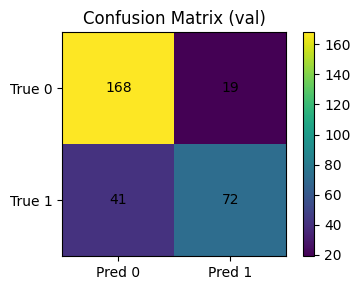

In [7]:

# Visualización rápida de la matriz de confusión
plt.figure(figsize=(4,3))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (val)")
plt.colorbar()
plt.xticks([0,1], ["Pred 0", "Pred 1"])
plt.yticks([0,1], ["True 0", "True 1"])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()



---
## 4. ¿Qué es *data leakage*?

**Leakage** ocurre cuando el modelo recibe información (directa o indirecta) que **no tendría disponible** en el momento de predecir en el mundo real.

Dos familias:
1) **Target leakage**: una variable contiene el target “disfrazado” (o calculado con el futuro).
2) **Preprocessing leakage**: el preprocesamiento usa información de test/val (ej. escalado con toda la data).

En ciencia de datos aplicada y en investigación, leakage produce conclusiones inválidas.



### 4.1 Ejemplo de *target leakage* (simulado)

Construimos una variable `leak_feature` que usa el target con un poco de ruido.
El desempeño se dispara, pero es un engaño: en producción esa variable no estaría.


In [8]:

# TARGET LEAKAGE (simulado)
leak_feature = y_clf + rng.normal(scale=0.05, size=len(y_clf))  # casi el target
X_leak = np.c_[X_clf, leak_feature]

Xl_train, Xl_val, Xl_test, yl_train, yl_val, yl_test = split_train_val_test(
    X_leak, y_clf, test_size=0.20, val_size=0.20, random_state=RANDOM_STATE, stratify=y_clf
)

logreg_leak = LogisticRegression(max_iter=5000)
logreg_leak.fit(Xl_train, yl_train)
p_val_leak = logreg_leak.predict_proba(Xl_val)[:, 1]

pd.DataFrame([
    clf_metrics(yl_val, p_log_val),
    clf_metrics(yl_val, p_val_leak),
], index=["LogReg (sin fuga)", "LogReg (CON fuga)"])


,Accuracy,Precision,Recall,F1,ROC_AUC,PR_AUC
LogReg (sin fuga),0.8,0.791209,0.637168,0.705882,0.870664,0.829018
LogReg (CON fuga),1.0,1.000000,1.000000,1.000000,1.000000,1.000000



### 4.2 Ejemplo de *preprocessing leakage*

Error común: **escalar con toda la data antes de hacer split**.
La solución: usar `Pipeline` para que el preprocesador se ajuste solo con `train`.


In [9]:

# MAL: escalado con toda la data (leakage)
scaler_bad = StandardScaler()
X_bad = scaler_bad.fit_transform(X_clf)  # miraste todo (incluyendo test)

Xb_train, Xb_val, Xb_test, yb_train, yb_val, yb_test = split_train_val_test(
    X_bad, y_clf, test_size=0.20, val_size=0.20, random_state=RANDOM_STATE, stratify=y_clf
)

bad_model = LogisticRegression(max_iter=5000)
bad_model.fit(Xb_train, yb_train)
p_bad_val = bad_model.predict_proba(Xb_val)[:, 1]

# BIEN: pipeline (scaler aprende solo del train)
good_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=5000))
])
good_pipe.fit(Xc_train, yc_train)
p_good_val = good_pipe.predict_proba(Xc_val)[:, 1]

pd.DataFrame([
    clf_metrics(yb_val, p_bad_val),
    clf_metrics(yc_val, p_good_val),
], index=["BAD (scaler antes del split)", "GOOD (Pipeline)"])


,Accuracy,Precision,Recall,F1,ROC_AUC,PR_AUC
BAD (scaler antes del split),0.8,0.791209,0.637168,0.705882,0.870759,0.829189
GOOD (Pipeline),0.8,0.791209,0.637168,0.705882,0.870759,0.829189



---
## 5. Ejemplo tabular real pequeño (desde URL)

Dataset: *Head Size vs Brain Weight* (regresión simple).  
Objetivo: predecir `Brain Weight(grams)` a partir de `Head Size(cm^3)`.


In [10]:

url = "https://media.geeksforgeeks.org/wp-content/cdn-uploads/20220522225116/headbrain11.csv"
df = pd.read_csv(url)
df.head()


,Head Size(cm^3),Brain Weight(grams)
0,4512,1530
1,3738,1297
2,4261,1335
3,3777,1282
4,4177,1590


In [11]:

X = df[["Head Size(cm^3)"]].copy()
y = df["Brain Weight(grams)"].copy()

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(
    X, y, test_size=0.20, val_size=0.20, random_state=RANDOM_STATE
)

base = DummyRegressor(strategy="mean")
base.fit(X_train, y_train)

model = LinearRegression()
model.fit(X_train, y_train)

yhat_base = base.predict(X_val)
yhat = model.predict(X_val)

pd.DataFrame([
    reg_metrics(y_val, yhat_base),
    reg_metrics(y_val, yhat),
], index=["Baseline(mean)", "LinearRegression"])


,MAE,RMSE,R2
Baseline(mean),97.206413,123.896973,-0.025111
LinearRegression,55.409113,68.624284,0.685511


/opt/homebrew/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


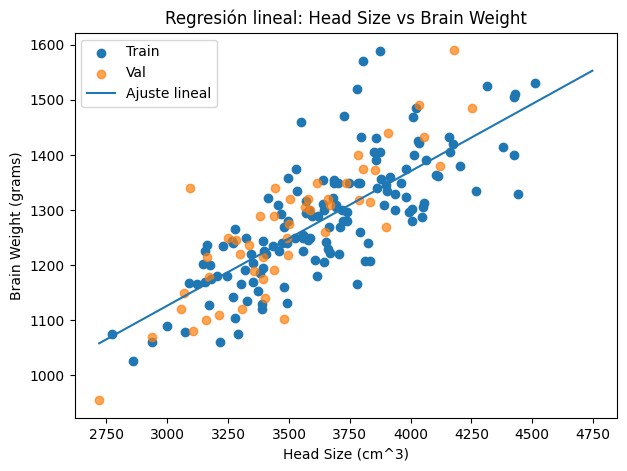

In [12]:

x_grid = np.linspace(X["Head Size(cm^3)"].min(), X["Head Size(cm^3)"].max(), 200).reshape(-1, 1)
y_grid = model.predict(x_grid)

plt.figure(figsize=(7,5))
plt.scatter(X_train["Head Size(cm^3)"], y_train, label="Train")
plt.scatter(X_val["Head Size(cm^3)"], y_val, label="Val", alpha=0.7)
plt.plot(x_grid[:, 0], y_grid, label="Ajuste lineal")
plt.xlabel("Head Size (cm^3)")
plt.ylabel("Brain Weight (grams)")
plt.title("Regresión lineal: Head Size vs Brain Weight")
plt.legend()
plt.show()


In [13]:

yhat_test = model.predict(X_test)
pd.DataFrame([reg_metrics(y_test, yhat_test)], index=["LinearRegression(TEST)"])


,MAE,RMSE,R2
LinearRegression(TEST),67.986139,80.837217,0.666941



---
## 6. Checklist de buenas prácticas (semana 1)

- [ ] Definí claramente **target** y **features** (y qué información está permitida).
- [ ] Hice split **antes** de decisiones de modelado.
- [ ] Construí un **baseline**.
- [ ] Usé `Pipeline` cuando hay preprocesamiento (para evitar leakage).
- [ ] Usé `val` para decisiones y `test` para evaluación final.
- [ ] Reporté métricas y al menos un gráfico diagnóstico.



---
## 7. Ejercicios (para discusión / entrega)

### Ejercicio 1 — Diseñar un split correcto
1) Para un problema **tabular** estándar, propone un split (porcentaje) `train/val/test` y justifica.  
2) ¿Qué cambia si el dataset es pequeño (n < 200)?

### Ejercicio 2 — Identificar leakage (casos cortos)
Indica si hay leakage y por qué:
- (a) Usar `StandardScaler().fit_transform(X_total)` antes del split.  
- (b) Imputar con la mediana usando todo el dataset antes del split.  
- (c) Incluir una variable “estado_final_del_trámite” para predecir si un trámite será aprobado.  
- (d) En series de tiempo, mezclar aleatoriamente registros de 2018–2024 para entrenar y probar.

### Ejercicio 3 — Baselines
1) Para regresión: ¿qué baseline usarías además de la media?  
2) Para clasificación desbalanceada: ¿por qué accuracy puede engañar?

### Ejercicio 4 — Mini-proyecto (10–20 min)
Elige un dataset pequeño (UCI / OpenML / Kaggle / datos.gov.co) y:
- define target y features,
- construye train/val/test,
- implementa baseline y un modelo simple,
- reporta métricas en val (y guarda test para después).
